# Compare Twitter and Reddit Populations

## Restrict this analysis to the sharing of political content

This script evaluates how similar subsets of Twitter and Reddit populations are within platform and across platform.
The populations we test are:
- Random US Twitter users active in 2015-2018
    - Must have tweeted >= 100 times in this time frame
- Politically engaged US Twitter users active in 2015-2018
    - Must have tweeted >= 100 times in this time frame
    - Must follow at least 5 politicians
- IRA Twitter accounts identified by Twitter
- Random Reddit accounts  active in 2015-2018
    - Must have posted/commented >= 100 times in this time frame
- Politically engaged Redditors  active in 2015-2018
    - Must have posted/commented >= 100 times in subreddits /r/politics identifies as US-political in this time frame
- IRA Reddit accounts identified by Reddit

In [1]:
%matplotlib inline

In [2]:
import json
import time
import string
import datetime
import matplotlib

import scipy.stats

import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt

In [3]:
import sklearn.preprocessing
import sklearn.metrics

In [4]:
from utils.youtube import strip_video_id_from_url

In [5]:
def convert_date(date):
    return datetime.datetime.strptime(date, "%a %b %d %H:%M:%S +0000 %Y")

def convert_time(timestamp):
    created_time = timestamp
    if ( isinstance(created_time, str) ):
        created_time = int(created_time)
        
    d = datetime.datetime.utcfromtimestamp(created_time)
    return d

def get_top_tlds(links_df, user_id_field, top_n=100):
    tld_user_counts = {}
    for tld, group in links_df.groupby("tld"):
        local_users = set(group[user_id_field])
        tld_user_counts[tld] = len(local_users)

    return sorted(tld_user_counts, key=tld_user_counts.get, reverse=True)[:top_n]

def links_df_to_shares(links_df, domains, user_id_field):
    user_shares = []

    for user,user_posts in links_df.groupby(user_id_field):
        local_tld_counts = dict(user_posts["tld"].value_counts().items())
        local_vector = [local_tld_counts.get(x, 0) for x in domains]
        user_shares.append([user] + local_vector)

    return pd.DataFrame(user_shares, columns=[user_id_field] + domains)

def links_to_norm_matrix(links_df, domains, user_id_field):
    if ( type(domains) == set ):
        domains = list(domains)
        
    shares_df = links_df_to_shares(links_df, domains, user_id_field)
    return sklearn.preprocessing.normalize(shares_df[domains], norm="l2", axis=1)

def get_top_channels(yt_df, user_id_field, top_n=100):
    channel_user_counts = {}
    for channel, group in yt_df.groupby("channel_id"):
        local_users = set(group[user_id_field])
        channel_user_counts[channel] = len(local_users)

    return sorted(channel_user_counts, key=channel_user_counts.get, reverse=True)[:top_n]

def channels_df_to_shares(links_df, channels, user_id_field):
    user_shares = []

    for user,user_posts in links_df.groupby(user_id_field):
        local_chan_counts = dict(user_posts["channel_id"].value_counts().items())
        local_vector = [local_chan_counts.get(x, 0) for x in channels]
        user_shares.append([user] + local_vector)

    return pd.DataFrame(user_shares, columns=[user_id_field] + channels)

def channels_to_norm_matrix(links_df, channels, user_id_field):
    if ( type(channels) == set ):
        channels = list(channels)
        
    shares_df = channels_df_to_shares(links_df, channels, user_id_field)
    return sklearn.preprocessing.normalize(shares_df[channels], norm="l2", axis=1)


In [6]:
political_domains_df = pd.read_csv("DomainIdeology.csv")
political_domains = set(political_domains_df["domain"].apply(str.lower))
print("Political Domains:", len(political_domains))

Political Domains: 145


In [7]:
bootstrap_count = 5000

In [8]:
short_domain_map = {
    "abcn.ws": "abcnews.go.com",
    "amzn.to": "amazon.com",
    "apne.ws": "apnews.com",
    "apple.co": "apple.com",
    "bbc.in": "bbc.com",
    "ble.ac": "bleacherreport.com",
    "bloom.bg": "bloomberg.com",
    "bzfd.it": "buzzfeed.com",
    "cbsloc.al": "cbslocal.com",
    "cnb.cx": "cnbc.com",
    "cnn.it": "cnn.com",
    "cnn.it": "cnn.com",
    "dailym.ai" : "dailymail.co.uk",
    "econ.st": "economist.com",
    "es.pn": "espn.com",
    "fxn.ws": "foxnews.com",
    "hill.cm": "thehill.com",
    "huff.to" : "huffingtonpost.com",
    "lat.ms": "latimes.com",
    "lnkd.in": "linkedin.com",
    "n.pr": "npr.org",
    "nbcnews.to": "nbcnews.com",
    "nydn.us": "nydailynews.com",
    "nyp.st": "nypost.com",
    "nyti.ms": "nytimes.com",
    "on.rt.com": "rt.com",
    "on.wsj.com": "wsj.com",
    "politi.co": "politico.com",
    "redd.it": "reddit.com",
    "reut.rs": "reuters.com",
    "thebea.st": "thedailybeast.com",
    "ti.me": "time.com",
    "tmblr.co": "tumblr.com",
    "usat.ly": "usatoday.com",
    "wapo.st": "washingtonpost.com",
    "wp.me": "wordpress.com",
    "wpo.st": "washingtonpost.com",
    "yhoo.it": "yahoo.com",
    "youtu.be": "youtube.com",
}

In [9]:
twitter_links_df_rand = pd.read_csv("twitter_random_us_sample_links.csv",
    converters={"created_at": convert_date})
twitter_links_df_poli = pd.read_csv("twitter_political_us_sample_links.csv",
    converters={"created_at": convert_date})
twitter_links_df_ira = pd.read_csv(
    "twitter_ira_links.csv",
    converters={"created_at": lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")}
)

In [10]:
twitter_links_df_rand["tld"] = twitter_links_df_rand["tld"].apply(lambda x: short_domain_map.get(x, x))
twitter_links_df_poli["tld"] = twitter_links_df_poli["tld"].apply(lambda x: short_domain_map.get(x, x))
twitter_links_df_ira["tld"] = twitter_links_df_ira["tld"].apply(lambda x: short_domain_map.get(x, x))

In [11]:
reddit_links_df_rand = pd.read_csv("reddit_random_links.csv",
    converters={"created_at": convert_time})
reddit_links_df_poli = pd.read_csv("reddit_political_links.csv",
    converters={"created_at": convert_time})
reddit_links_df_ira = pd.read_csv("reddit_troll_links.csv",
    converters={"created_at": convert_time}
)

In [12]:
reddit_links_df_rand["tld"] = reddit_links_df_rand["tld"].apply(lambda x: short_domain_map.get(x, x))
reddit_links_df_poli["tld"] = reddit_links_df_poli["tld"].apply(lambda x: short_domain_map.get(x, x))
reddit_links_df_ira["tld"] = reddit_links_df_ira["tld"].apply(lambda x: short_domain_map.get(x, x))

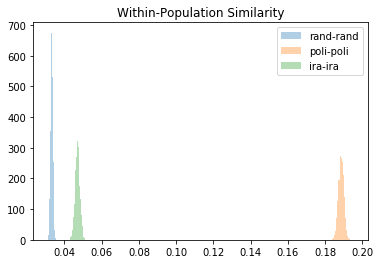

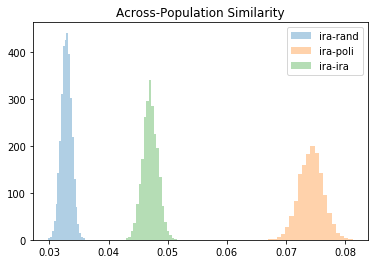

In [13]:
twitter_user_links_mat_rand = links_to_norm_matrix(twitter_links_df_rand, political_domains, "user_id")
twitter_user_links_mat_poli = links_to_norm_matrix(twitter_links_df_poli, political_domains, "user_id")
twitter_user_links_mat_ira = links_to_norm_matrix(twitter_links_df_ira, political_domains, "user_id")

# Calculate pairwise similarity among users across populations
t2t_rand_rand_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_rand, twitter_user_links_mat_rand)
t2t_poli_poli_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_poli, twitter_user_links_mat_poli)
t2t_ira_ira_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_ira, twitter_user_links_mat_ira)

t2t_ira_rand_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(twitter_links_df_ira, political_domains, "user_id"), 
    links_to_norm_matrix(twitter_links_df_rand, political_domains, "user_id"))
t2t_ira_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(twitter_links_df_ira, political_domains, "user_id"), 
    links_to_norm_matrix(twitter_links_df_poli, political_domains, "user_id"))
t2t_rand_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(twitter_links_df_rand, political_domains, "user_id"), 
    links_to_norm_matrix(twitter_links_df_poli, political_domains, "user_id"))

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
#. note the minus 1 and reduction of shape by 1 for the within-platform groups, which I do to remove the 
#. self-similarity effect
t2t_rand_rand_sim_avg = (np.sum(t2t_rand_rand_sim, axis=1) - 1) / (twitter_user_links_mat_rand.shape[0] - 1)
t2t_poli_poli_sim_avg = (np.sum(t2t_poli_poli_sim, axis=1) - 1) / (twitter_user_links_mat_poli.shape[0] - 1)
t2t_ira_ira_sim_avg = (np.sum(t2t_ira_ira_sim, axis=1) - 1) / (twitter_user_links_mat_ira.shape[0] - 1)
t2t_ira_rand_sim_avg = np.mean(t2t_ira_rand_sim, axis=1)
t2t_ira_poli_sim_avg = np.mean(t2t_ira_poli_sim, axis=1)
t2t_ira_ira_sim_avg = np.mean(t2t_ira_ira_sim, axis=1)
t2t_rand_poli_sim_avg = np.mean(t2t_rand_poli_sim, axis=1)

# Show similarity distribution within populations in this platform
t2t_rand_rand_sim_avg_bootstrap = [sklearn.utils.resample(t2t_rand_rand_sim_avg, replace=True, n_samples=t2t_rand_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_poli_poli_sim_avg_bootstrap = [sklearn.utils.resample(t2t_poli_poli_sim_avg, replace=True, n_samples=t2t_poli_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_ira_sim_avg, replace=True, n_samples=t2t_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(t2t_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="rand-rand")
plt.hist(t2t_poli_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="poli-poli")
plt.hist(t2t_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Within-Population Similarity")
plt.legend()
plt.show()

# Show similarity distribution across populations in this platform
t2t_ira_rand_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_rand_sim_avg, replace=True, n_samples=t2t_ira_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_ira_poli_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_poli_sim_avg, replace=True, n_samples=t2t_ira_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_ira_sim_avg, replace=True, n_samples=t2t_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(t2t_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-rand")
plt.hist(t2t_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-poli")
plt.hist(t2t_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Across-Population Similarity")
plt.legend()
plt.show()

In [14]:
print("Random:", np.array(t2t_rand_rand_sim_avg_bootstrap).mean(), np.array(t2t_rand_rand_sim_avg_bootstrap).var())
print("Political:", np.array(t2t_poli_poli_sim_avg_bootstrap).mean(), np.array(t2t_poli_poli_sim_avg_bootstrap).var())
print("Russian IRA:", np.array(t2t_ira_ira_sim_avg_bootstrap).mean(), np.array(t2t_ira_ira_sim_avg_bootstrap).var())


Random: 0.03319582131757208 3.565801997085642e-07
Political: 0.18859678973270796 1.989976063518956e-06
Russian IRA: 0.04703579201107927 1.5743112642330297e-06


In [15]:
print("Random-Random:", np.array(t2t_rand_rand_sim_avg_bootstrap).mean(), np.array(t2t_rand_rand_sim_avg_bootstrap).var())
print("Russian IRA-Random:", np.array(t2t_ira_rand_sim_avg_bootstrap).mean(), np.array(t2t_ira_rand_sim_avg_bootstrap).var())
print("Russian IRA-Political:", np.array(t2t_ira_poli_sim_avg_bootstrap).mean(), np.array(t2t_ira_poli_sim_avg_bootstrap).var())


Random-Random: 0.03319582131757208 3.565801997085642e-07
Russian IRA-Random: 0.032873623262569006 7.866783722951091e-07
Russian IRA-Political: 0.07422925334659246 4.057517429217427e-06


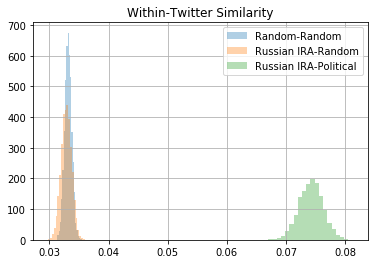

In [20]:
plt.hist(t2t_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random-Random")
plt.hist(t2t_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Random")
plt.hist(t2t_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Political")

plt.title("Within-Twitter Similarity")
plt.legend()
plt.grid()
plt.show()

In [21]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    t2t_rand_rand_sim_avg_bootstrap, 
    t2t_ira_rand_sim_avg_bootstrap, 
    t2t_ira_poli_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    t2t_ira_rand_sim_avg_bootstrap, 
    t2t_ira_poli_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between IRA-Rand and IRA-Poli:", p_val, t_stat)

p-value for ANOVA: 0.0 1631225.6419126347
p-value for Welch's t-Test between IRA-Rand and IRA-Poli: 0.0 -1328.511646151757


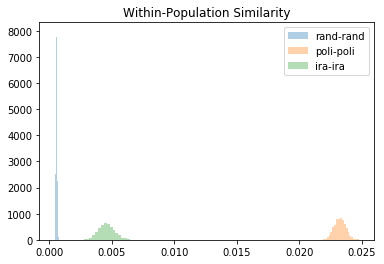

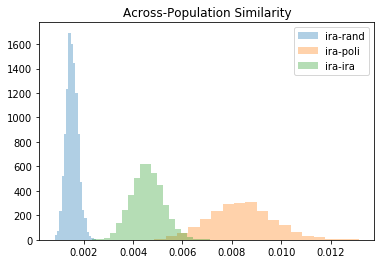

In [22]:
reddit_user_links_mat_rand = links_to_norm_matrix(reddit_links_df_rand, political_domains, "user_name")
reddit_user_links_mat_poli = links_to_norm_matrix(reddit_links_df_poli, political_domains, "user_name")
reddit_user_links_mat_ira = links_to_norm_matrix(reddit_links_df_ira, political_domains, "user_name")

# Calculate pairwise similarity among users across populations
r2r_rand_rand_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_rand, reddit_user_links_mat_rand)
r2r_poli_poli_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_poli, reddit_user_links_mat_poli)
r2r_ira_ira_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_ira, reddit_user_links_mat_ira)

r2r_ira_rand_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(reddit_links_df_ira, political_domains, "user_name"), 
    links_to_norm_matrix(reddit_links_df_rand, political_domains, "user_name"))
r2r_ira_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(reddit_links_df_ira, political_domains, "user_name"), 
    links_to_norm_matrix(reddit_links_df_poli, political_domains, "user_name"))
r2r_rand_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(reddit_links_df_rand, political_domains, "user_name"), 
    links_to_norm_matrix(reddit_links_df_poli, political_domains, "user_name"))

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
#. note the minus 1 and reduction of shape by 1 for the within-platform groups, which I do to remove the 
#. self-similarity effect
r2r_rand_rand_sim_avg = (np.sum(r2r_rand_rand_sim, axis=1) - 1) / (reddit_user_links_mat_rand.shape[0] - 1)
r2r_poli_poli_sim_avg = (np.sum(r2r_poli_poli_sim, axis=1) - 1) / (reddit_user_links_mat_poli.shape[0] - 1)
r2r_ira_ira_sim_avg = (np.sum(r2r_ira_ira_sim, axis=1) - 1) / (reddit_user_links_mat_ira.shape[0] - 1)
r2r_ira_rand_sim_avg = np.mean(r2r_ira_rand_sim, axis=1)
r2r_ira_poli_sim_avg = np.mean(r2r_ira_poli_sim, axis=1)
r2r_ira_ira_sim_avg = np.mean(r2r_ira_ira_sim, axis=1)
r2r_rand_poli_sim_avg = np.mean(r2r_rand_poli_sim, axis=1)

# Show similarity distribution within populations in this platform
r2r_rand_rand_sim_avg_bootstrap = [sklearn.utils.resample(r2r_rand_rand_sim_avg, replace=True, n_samples=r2r_rand_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_poli_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2r_poli_poli_sim_avg, replace=True, n_samples=r2r_poli_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_ira_sim_avg, replace=True, n_samples=r2r_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(r2r_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="rand-rand")
plt.hist(r2r_poli_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="poli-poli")
plt.hist(r2r_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Within-Population Similarity")
plt.legend()
plt.show()

# Show similarity distribution across populations in this platform
r2r_ira_rand_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_rand_sim_avg, replace=True, n_samples=r2r_ira_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_ira_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_poli_sim_avg, replace=True, n_samples=r2r_ira_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_ira_sim_avg, replace=True, n_samples=r2r_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(r2r_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-rand")
plt.hist(r2r_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-poli")
plt.hist(r2r_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Across-Population Similarity")
plt.legend()
plt.show()

In [23]:
print("Random:", np.array(r2r_rand_rand_sim_avg_bootstrap).mean(), np.array(r2r_rand_rand_sim_avg_bootstrap).var())
print("Political:", np.array(r2r_poli_poli_sim_avg_bootstrap).mean(), np.array(r2r_poli_poli_sim_avg_bootstrap).var())
print("Russian IRA:", np.array(r2r_ira_ira_sim_avg_bootstrap).mean(), np.array(r2r_ira_ira_sim_avg_bootstrap).var())


Random: 0.0005671690976958448 2.2814732844769146e-09
Political: 0.02327055747483294 2.209898155235904e-07
Russian IRA: 0.0045691645476287224 4.029179803068467e-07


In [24]:
print("Random-Random:", np.array(r2r_rand_rand_sim_avg_bootstrap).mean(), np.array(r2r_rand_rand_sim_avg_bootstrap).var())
print("Russian IRA-Random:", np.array(r2r_ira_rand_sim_avg_bootstrap).mean(), np.array(r2r_ira_rand_sim_avg_bootstrap).var())
print("Russian IRA-Political:", np.array(r2r_ira_poli_sim_avg_bootstrap).mean(), np.array(r2r_ira_poli_sim_avg_bootstrap).var())


Random-Random: 0.0005671690976958448 2.2814732844769146e-09
Russian IRA-Random: 0.0015310091035207545 5.8932856006858025e-08
Russian IRA-Political: 0.008389316117803997 1.6287264924779783e-06


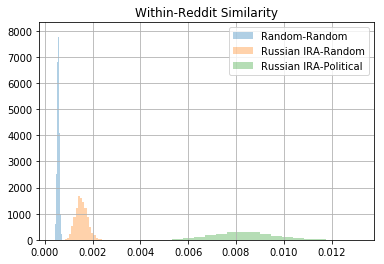

In [25]:
plt.hist(r2r_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random-Random")
plt.hist(r2r_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Random")
plt.hist(r2r_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Political")

plt.title("Within-Reddit Similarity")
plt.legend()
plt.grid()
plt.show()

In [26]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    r2r_rand_rand_sim_avg_bootstrap, 
    r2r_ira_rand_sim_avg_bootstrap, 
    r2r_ira_poli_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2r_ira_rand_sim_avg_bootstrap, 
    r2r_ira_poli_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between IRA-Rand and IRA-Poli:", p_val, t_stat)

p-value for ANOVA: 0.0 161439.84894038283
p-value for Welch's t-Test between IRA-Rand and IRA-Poli: 0.0 -373.2639917727016


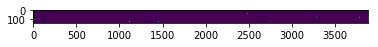

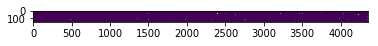

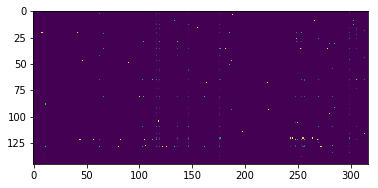

In [27]:
plt.imshow(reddit_user_links_mat_rand.T)
plt.show()
plt.imshow(reddit_user_links_mat_poli.T)
plt.show()
plt.imshow(reddit_user_links_mat_ira.T)
plt.show()

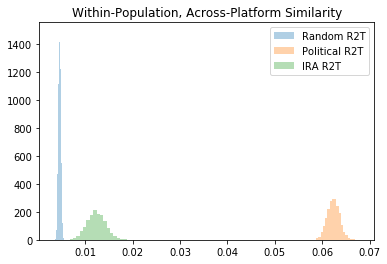

In [28]:

r2t_rand_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(reddit_links_df_rand, political_domains, "user_name"), 
    links_to_norm_matrix(twitter_links_df_rand, political_domains, "user_id"))
r2t_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(reddit_links_df_poli, political_domains, "user_name"), 
    links_to_norm_matrix(twitter_links_df_poli, political_domains, "user_id"))
r2t_ira_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(reddit_links_df_ira, political_domains, "user_name"), 
    links_to_norm_matrix(twitter_links_df_ira, political_domains, "user_id"))

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
r2t_rand_sim_avg = np.mean(r2t_rand_sim, axis=1)
r2t_poli_sim_avg = np.mean(r2t_poli_sim, axis=1)
r2t_ira_sim_avg = np.mean(r2t_ira_sim, axis=1)

# Show similarity distribution within populations in this platform
r2t_rand_sim_avg_bootstrap = [sklearn.utils.resample(r2t_rand_sim_avg, replace=True, n_samples=r2t_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2t_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2t_poli_sim_avg, replace=True, n_samples=r2t_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2t_ira_sim_avg_bootstrap = [sklearn.utils.resample(r2t_ira_sim_avg, replace=True, n_samples=r2t_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(r2t_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random R2T")
plt.hist(r2t_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Political R2T")
plt.hist(r2t_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="IRA R2T")

plt.title("Within-Population, Across-Platform Similarity")
plt.legend()
plt.show()


In [29]:
print("Random-R2T:", np.array(r2t_rand_sim_avg_bootstrap).mean(), np.array(r2t_rand_sim_avg_bootstrap).var())
print("Political-R2T:", np.array(r2t_poli_sim_avg_bootstrap).mean(), np.array(r2t_poli_sim_avg_bootstrap).var())
print("Russian IRA-R2T:", np.array(r2t_ira_sim_avg_bootstrap).mean(), np.array(r2t_ira_sim_avg_bootstrap).var())


Random-R2T: 0.0045585611078933904 7.393478323046608e-08
Political-R2T: 0.062344553032771435 1.6977119870974406e-06
Russian IRA-R2T: 0.012359050029375979 3.953400967784743e-06


In [31]:
print("Russian IRA-R2T:", np.array(r2t_ira_sim_avg_bootstrap).mean(), np.array(r2t_ira_sim_avg_bootstrap).var())
print("Russian IRA-RRandom:", np.array(r2r_ira_rand_sim_avg_bootstrap).mean(), np.array(r2r_ira_rand_sim_avg_bootstrap).var())
print("Russian IRA-RPoli:", np.array(r2r_ira_poli_sim_avg_bootstrap).mean(), np.array(r2r_ira_poli_sim_avg_bootstrap).var())


Russian IRA-R2T: 0.012359050029375979 3.953400967784743e-06
Russian IRA-RRandom: 0.0015310091035207545 5.8932856006858025e-08
Russian IRA-RPoli: 0.008389316117803997 1.6287264924779783e-06


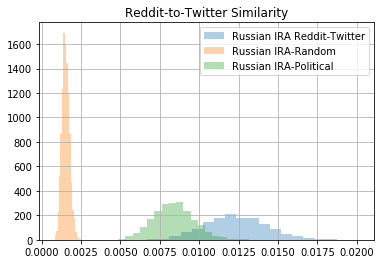

In [32]:
plt.hist(r2t_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA Reddit-Twitter")
plt.hist(r2r_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Random")
plt.hist(r2r_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Political")

plt.title("Reddit-to-Twitter Similarity")
plt.legend()
plt.grid()
plt.show()

In [43]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    r2t_ira_sim_avg_bootstrap, 
    r2r_ira_rand_sim_avg_bootstrap, 
    r2r_ira_poli_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2t_ira_sim_avg_bootstrap, 
    r2r_ira_rand_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Twitter-Reddit and IRA-Rand:", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2t_ira_sim_avg_bootstrap,
    r2r_ira_poli_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Twitter-Reddit and IRA-Poli:", p_val, t_stat)

p-value for ANOVA: 0.0 79774.72952963365
p-value for Welch's t-Test between Twitter-Reddit and IRA-Rand: 0.0 382.20197551815085
p-value for Welch's t-Test between Twitter-Reddit and IRA-Poli: 0.0 118.7963483737694


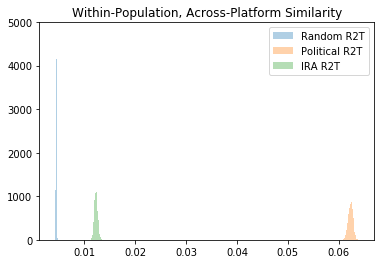

In [33]:
t2r_rand_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(twitter_links_df_rand, political_domains, "user_id"), 
    links_to_norm_matrix(reddit_links_df_rand, political_domains, "user_name"))
t2r_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(twitter_links_df_poli, political_domains, "user_id"), 
    links_to_norm_matrix(reddit_links_df_poli, political_domains, "user_name"))
t2r_ira_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(twitter_links_df_ira, political_domains, "user_id"), 
    links_to_norm_matrix(reddit_links_df_ira, political_domains, "user_name"))

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
t2r_rand_sim_avg = np.mean(t2r_rand_sim, axis=1)
t2r_poli_sim_avg = np.mean(t2r_poli_sim, axis=1)
t2r_ira_sim_avg = np.mean(t2r_ira_sim, axis=1)

# Show similarity distribution within populations in this platform
t2r_rand_sim_avg_bootstrap = [sklearn.utils.resample(t2r_rand_sim_avg, replace=True, n_samples=t2r_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2r_poli_sim_avg_bootstrap = [sklearn.utils.resample(t2r_poli_sim_avg, replace=True, n_samples=t2r_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2r_ira_sim_avg_bootstrap = [sklearn.utils.resample(t2r_ira_sim_avg, replace=True, n_samples=t2r_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(t2r_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random R2T")
plt.hist(t2r_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Political R2T")
plt.hist(t2r_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="IRA R2T")

plt.title("Within-Population, Across-Platform Similarity")
plt.legend()
plt.show()



In [34]:
print("Russian IRA-T2R:", np.array(t2r_ira_sim_avg_bootstrap).mean(), np.array(t2r_ira_sim_avg_bootstrap).var())
print("Russian IRA-TRandom:", np.array(t2t_ira_rand_sim_avg_bootstrap).mean(), np.array(t2t_ira_rand_sim_avg_bootstrap).var())
print("Russian IRA-TPoli:", np.array(t2t_ira_poli_sim_avg_bootstrap).mean(), np.array(t2t_ira_poli_sim_avg_bootstrap).var())


Russian IRA-T2R: 0.01235053114152804 1.1287607362730598e-07
Russian IRA-TRandom: 0.032873623262569006 7.866783722951091e-07
Russian IRA-TPoli: 0.07422925334659246 4.057517429217427e-06


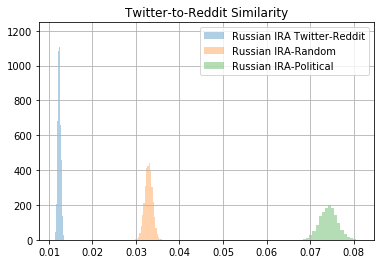

In [35]:
plt.hist(t2r_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA Twitter-Reddit")
plt.hist(t2t_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Random")
plt.hist(t2t_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Political")

plt.title("Twitter-to-Reddit Similarity")
plt.legend()
plt.grid()
plt.show()

In [42]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    t2r_ira_sim_avg_bootstrap, 
    t2t_ira_rand_sim_avg_bootstrap, 
    t2t_ira_poli_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    t2r_ira_sim_avg_bootstrap, 
    t2t_ira_rand_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Twitter-Reddit and IRA-Rand:", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    t2r_ira_sim_avg_bootstrap,
    t2t_ira_poli_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Twitter-Reddit and IRA-Poli:", p_val, t_stat)

p-value for ANOVA: 0.0 3005438.3763986533
p-value for Welch's t-Test between Twitter-Reddit and IRA-Rand: 0.0 -1529.9267416724376
p-value for Welch's t-Test between Twitter-Reddit and IRA-Poli: 0.0 -2142.3695533366053


In [40]:
## Full Cross-Comparison

### Other comparisons
t2t_rand_poli_sim_avg_bootstrap = [sklearn.utils.resample(t2t_rand_poli_sim_avg, replace=True, n_samples=t2t_rand_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_rand_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2r_rand_poli_sim_avg, replace=True, n_samples=r2r_rand_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]




In [41]:
print("\t", "Random", "\t\t", "Political", "\t\t", "IRA", "\t\t", "Other")
print("\t", "mu", "sigma^2", "mu", "sigma^2", "mu", "sigma^2", "mu", "sigma^2")

print("Reddit")
print("Random:", 
    np.array(r2r_rand_rand_sim_avg_bootstrap).mean(), 
    np.array(r2r_rand_rand_sim_avg_bootstrap).var(),
    np.array(r2r_rand_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_rand_poli_sim_avg_bootstrap).var(),
    np.array(r2r_ira_rand_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_rand_sim_avg_bootstrap).var(),
    np.array(r2t_rand_sim_avg_bootstrap).mean(), 
    np.array(r2t_rand_sim_avg_bootstrap).var(),
)

print("Political:", 
    np.array(r2r_rand_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_rand_poli_sim_avg_bootstrap).var(),
    np.array(r2r_poli_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_poli_poli_sim_avg_bootstrap).var(),
    np.array(r2r_ira_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_poli_sim_avg_bootstrap).var(),
    np.array(r2t_poli_sim_avg_bootstrap).mean(), 
    np.array(r2t_poli_sim_avg_bootstrap).var(),
)

print("IRA:", 
    np.array(r2r_ira_rand_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_rand_sim_avg_bootstrap).var(),
    np.array(r2r_ira_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_poli_sim_avg_bootstrap).var(),
    np.array(r2r_ira_ira_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_ira_sim_avg_bootstrap).var(),
    np.array(r2t_ira_sim_avg_bootstrap).mean(), 
    np.array(r2t_ira_sim_avg_bootstrap).var(),
)

print("Twitter")
print("Random:", 
    np.array(t2t_rand_rand_sim_avg_bootstrap).mean(), 
    np.array(t2t_rand_rand_sim_avg_bootstrap).var(),
    np.array(t2t_rand_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_rand_poli_sim_avg_bootstrap).var(),
    np.array(t2t_ira_rand_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_rand_sim_avg_bootstrap).var(),
    np.array(t2r_rand_sim_avg_bootstrap).mean(), 
    np.array(t2r_rand_sim_avg_bootstrap).var(),
)

print("Political:", 
    np.array(t2t_rand_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_rand_poli_sim_avg_bootstrap).var(),
    np.array(t2t_poli_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_poli_poli_sim_avg_bootstrap).var(),
    np.array(t2t_ira_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_poli_sim_avg_bootstrap).var(),
    np.array(t2r_poli_sim_avg_bootstrap).mean(), 
    np.array(t2r_poli_sim_avg_bootstrap).var(),
)

print("IRA:", 
    np.array(t2t_ira_rand_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_rand_sim_avg_bootstrap).var(),
    np.array(t2t_ira_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_poli_sim_avg_bootstrap).var(),
    np.array(t2t_ira_ira_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_ira_sim_avg_bootstrap).var(),
    np.array(t2r_ira_sim_avg_bootstrap).mean(), 
    np.array(t2r_ira_sim_avg_bootstrap).var(),
)


	 Random 		 Political 		 IRA 		 Other
	 mu sigma^2 mu sigma^2 mu sigma^2 mu sigma^2
Reddit
Random: 0.0005671690976958448 2.2814732844769146e-09 0.004018674517736038 5.497349876368375e-08 0.0015310091035207545 5.8932856006858025e-08 0.0045585611078933904 7.393478323046608e-08
Political: 0.004018674517736038 5.497349876368375e-08 0.02327055747483294 2.209898155235904e-07 0.008389316117803997 1.6287264924779783e-06 0.062344553032771435 1.6977119870974406e-06
IRA: 0.0015310091035207545 5.8932856006858025e-08 0.008389316117803997 1.6287264924779783e-06 0.0045691645476287224 4.029179803068467e-07 0.012359050029375979 3.953400967784743e-06
Twitter
Random: 0.03319582131757208 3.565801997085642e-07 0.07693910546035343 1.948579828877555e-06 0.032873623262569006 7.866783722951091e-07 0.00455574946886422 7.23809096800057e-09
Political: 0.07693910546035343 1.948579828877555e-06 0.18859678973270796 1.989976063518956e-06 0.07422925334659246 4.057517429217427e-06 0.062318266893042804 2.187811677748593